In [1]:
import pandas as pd

Task A: Data Cleaning & Exploration

In [2]:
# Step 1: Load dataset
spam_df=pd.read_csv('spam.csv', encoding='latin-1')


In [3]:
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
#As per above output, there seem to unecessary columns like Unnamed:2, Unnamed 3, hence to clean the dataset
spam_revised_df=spam_df[['v1','v2']]

In [5]:
spam_revised_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Step 3: Rename columns
spam_revised_df.columns=['label','text']
spam_revised_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#Step 4: Encode labels
spam_revised_df['label'] = spam_revised_df['label'].map({'ham': 0, 'spam': 1})

spam_revised_df.head()

/tmp/ipython-input-3147571401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_revised_df['label'] = spam_revised_df['label'].map({'ham': 0, 'spam': 1})


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#Step 5: Show dataset shape and counts

spam_revised_df.groupby('label').count()

,text
label,
0,4825
1,747


In [11]:
spam_revised_df.shape

(5572, 2)

In [12]:
## As per the above summary, it appears there are 5572 texts in the data, out of which 4825 are ham and 747 are spam.

In [13]:
# Counts
class_counts = spam_revised_df['label'].value_counts()

# Percentages
class_percent = spam_revised_df['label'].value_counts(normalize=True) * 100
print(class_counts)
print(class_percent)

label
0    4825
1     747
Name: count, dtype: int64
label
0    86.593683
1    13.406317
Name: proportion, dtype: float64


In [14]:
## As per above summary, it appears ~87% of the texts are ham and ~13% are spam. This indicates a class imbalance, where ham messages significantly outnumber spam messages. Such imbalance is common in real-world spam detection problems and must be considered during model evaluation (e.g., using precision, recall, and F1-score instead of relying only on accuracy).

 Task B: Pre-processing for RNN

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

X = spam_revised_df['text'].astype(str).values
y = spam_revised_df['label'].values

# Step 1: Split off 10% test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Step 2: Split remaining 90% into train (80%) and val (10%)
# 10% out of total = 1/9 of the remaining 90% (≈ 0.1111)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

print("\nClass balance check:")
print("Train:", np.bincount(y_train))
print("Val  :", np.bincount(y_val))
print("Test :", np.bincount(y_test))


Train size: 4456
Validation size: 558
Test size: 558

Class balance check:
Train: [3859  597]
Val  : [483  75]
Test : [483  75]


In [16]:
# the above output showcases that for training, validation and test dataset - in all cases spam constitutes 13% of the dataset which is representative of the overall sample. Hence stratified splitting was successful.

In [17]:
# Word level tokenisation
from tensorflow.keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

print("Total unique tokens found:", len(tokenizer.word_index) + 1)

Total unique tokens found: 7953


In [18]:
# This means that across all the texts in the training data, 7953 unique words were found. The vocabulary cap of 10,000 is not limiting anything.

In [19]:
# Convert text to sequences and pad
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_sequences = tokenizer.texts_to_sequences(X_train)
seq_lengths = [len(seq) for seq in train_sequences]

print("Max length:", np.max(seq_lengths))
print("Mean length:", np.mean(seq_lengths))
print("90th percentile:", int(np.percentile(seq_lengths, 90)))
print("95th percentile:", int(np.percentile(seq_lengths, 95)))
print("99th percentile:", int(np.percentile(seq_lengths, 99)))


Max length: 189
Mean length: 15.828321364452425
90th percentile: 30
95th percentile: 33
99th percentile: 54


In [20]:
# The mean length of 16 indicates that the SMS messages are generally short and the dataset is suited for simpleRNN (sequences are not very long)

In [21]:
# For this dataset, best to set the max_len closer to 95th or 99th percentile - which allows to retain almost all information while avoiding excessive padding and computational overhead

In [22]:
MAX_LEN = 54 # Set to 99th percentile as explained above to cover 99% cases
# Convert and pad
# Convert all splits to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

print("Shapes after padding:")
print("X_train_pad:", X_train_pad.shape, " y_train:", y_train.shape)
print("X_val_pad  :", X_val_pad.shape,   " y_val  :", y_val.shape)
print("X_test_pad :", X_test_pad.shape,  " y_test :", y_test.shape)


Shapes after padding:
X_train_pad: (4456, 54)  y_train: (4456,)
X_val_pad  : (558, 54)  y_val  : (558,)
X_test_pad : (558, 54)  y_test : (558,)


In [23]:
# The training, validation and test dataset all have 4456, 558, 558 rows respectively- same as what they were before the padding exercise.
# The column 54 represents that each text is represented as a vector of 54.
# This sequence length is good for simpleRNN

In [25]:
## Why this vocabulary size?:
 # This dataset contains only 7953 words but we chose keeping the max vocab at 10k ensures we reduce noise from rare tokens while not missing out on any important words.
# ○ Why this max sequence length?
#54 was chosen because it covers 99% of the cases. This preserves almost all messages without excessive padding. Keeps the sequence manageable for RNN.
# ○ How do you handle unknown words?
# We use oov_token="<oov>" in the tokenizer. ANy word not seen during training or outside the vocabulary is mapped to this special token. This ensures handling of new values during validation and testing.

Task C: Build and train the vanilla RNN model

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

vocab_in_use = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)

EMBED_DIM = 64 # Just a design choice given our dataset size of ~5k samples
RNN_UNITS = 64
DROPOUT_RATE = 0.3

model = Sequential([
    Embedding(input_dim=vocab_in_use, output_dim=EMBED_DIM, input_shape=(MAX_LEN,)),
    SimpleRNN(RNN_UNITS),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       508,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,313 (1.97 MB)

 Trainable params: 517,313 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# The above means that each word is represented by a  64 dimensional dense vector.
# hence no of embeddings params are : 7953 vocab size x 64 vector size = 508992 params
# Param formula for simple RNN is 64x(64+64+1)=64x 129 = 8256
# Dropouts has no trainable parameters. This means the model would randomly drop parameters to prevent overfitting.
# Dense output layer means 64 inputs x 1 output + 1 bias= 65 params
# Hence total params across layers total upto 517,313. Majority of the params are in the embedding layer which is normal for NLP.

In [32]:
# Train with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3, #If validation loss does not improve for 3 consecutive epochs
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15, # this is a reasonable upper limit since for the no of full pass over training samples given this is for early stopping.
    batch_size=32,#32 is a standard, well-balanced default value.
    callbacks=[early_stop],
    verbose=1 # to be able to see training progress
)


Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8388 - loss: 0.4410 - val_accuracy: 0.8620 - val_loss: 0.3928
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8699 - loss: 0.3457 - val_accuracy: 0.8907 - val_loss: 0.2883
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9437 - loss: 0.1705 - val_accuracy: 0.9086 - val_loss: 0.3200
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9628 - loss: 0.1298 - val_accuracy: 0.8781 - val_loss: 0.3114
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9787 - loss: 0.0733 - val_accuracy: 0.9122 - val_loss: 0.2646
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9873 - loss: 0.0494 - val_accuracy: 0.9283 - val_loss: 0.2538
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9795 - loss: 0.0677 - val_accuracy: 0.9247 - val_loss: 0.2273
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9955 - loss: 0.0146 - val_accu

In [34]:
# As we see in the above epoch runs, the training loss continuously kept falling reaching a min of 0.014. This means model is fitting the data very closely
# Validation loss reached the mini at Epoch 7 with value of 0.2273 - showcasing that post with increase in validation loss - we are actually overfitting epoch 8 onwards.
# Hence given the minimisation of validation loss at epoch 7, our final modle wights will correspond to run 7, since we put restore_best_weights=true
# Training accuracy ≈ 99% ; Validation accuracy ≈ 92–93% ; That ~6–7% gap confirms mild overfitting — normal for RNNs on small datasets.

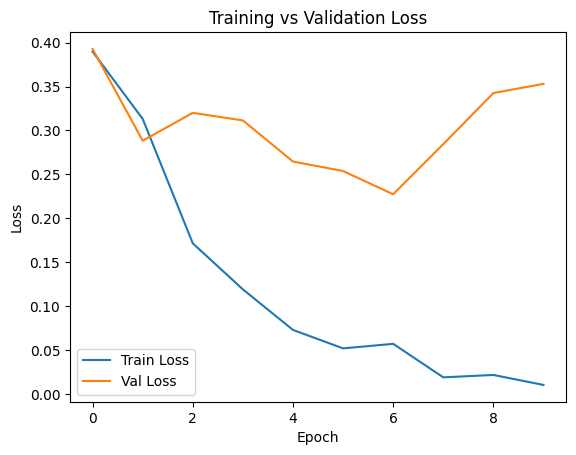

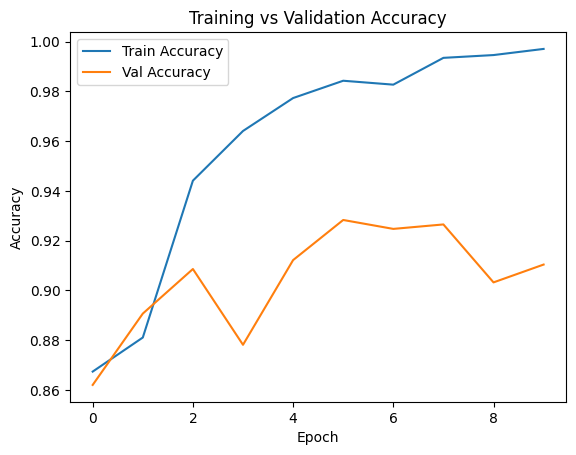

In [35]:
# Plot training curves (Loss as well as accuracy)
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [36]:
# the above graphs re-emphasise what we learned earlier- training steadily declines, but the validation loss post the 7th epoch begins increasing. Making the 7th epoch weights the most optimal.
# the 2nd graph on accuracy, clearly shows that upto 7th epoch there is increasing accuracy which plateaus after 7th epoch- in case of both training and validation accuracy.

Task D: Evaluation and Error analysis

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Get predicted probabilities
y_test_prob = model.predict(X_test_pad)

# Convert probabilities to class labels (threshold = 0.5)
y_test_pred = (y_test_prob > 0.5).astype(int)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [38]:
#calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Test Accuracy :", round(accuracy, 4))
print("Test Precision:", round(precision, 4))
print("Test Recall   :", round(recall, 4))
print("Test F1-score :", round(f1, 4))


Test Accuracy : 0.9355
Test Precision: 0.8095
Test Recall   : 0.68
Test F1-score : 0.7391


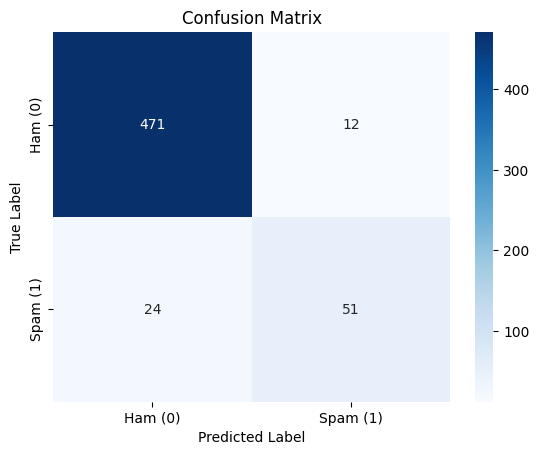

Confusion Matrix:
 [[471  12]
 [ 24  51]]


In [39]:
#Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (0)', 'Spam (1)'],
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", cm)


In [40]:
# F-1 score being 0.7391 showcases that there is a good balance between precision and recall.
# The model performs very well on ham messages - see accuracy of 94%
# It struggles more with detecting spam- 24 spam messages missed
# Precision is higher than recall, meaning the model avoids false alarms but at the cost of missing some spam.

In [41]:
# This is in line with model expectations, precision is more important here, since ideally any ham messages shouldn't get mis-labeled as spam and missed by the caller.

In [42]:
# Flatten probabilities
y_test_prob = y_test_prob.flatten()

# Convert to predicted labels
y_test_pred = (y_test_prob > 0.5).astype(int)

# Create results DataFrame
results_df = pd.DataFrame({
    "actual_label": y_test,
    "predicted_probability": y_test_prob,
    "predicted_label": y_test_pred,
    "text": X_test
})

results_df

,actual_label,predicted_probability,predicted_label,text
0,0,0.001552,0,I am not sure about night menu. . . I know onl...
1,1,0.992091,1,"Loan for any purpose å£500 - å£75,000. Homeown..."
2,0,0.001650,0,K I'll call you when I'm close
3,0,0.002229,0,Hurt me... Tease me... Make me cry... But in t...
4,1,0.931491,1,No. 1 Nokia Tone 4 ur mob every week! Just txt...
...,...,...,...,...
553,1,0.990426,1,+123 Congratulations - in this week's competit...
554,0,0.003788,0,If you ask her or she say any please message.
555,0,0.001785,0,"\NONE!NOWHERE IKNO DOESDISCOUNT!SHITINNIT\"""""
556,0,0.013504,0,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...


In [43]:
misclassified_df = results_df[
    results_df["actual_label"] != results_df["predicted_label"]
]

print("Total misclassified:", len(misclassified_df))

misclassified_df


Total misclassified: 36


,actual_label,predicted_probability,predicted_label,text
22,1,0.191579,0,Get the official ENGLAND poly ringtone or colo...
27,0,0.667950,1,"Princess, is your kitty shaved or natural?"
55,1,0.002514,0,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...
103,1,0.001459,0,Hi if ur lookin 4 saucy daytime fun wiv busty ...
136,0,0.916023,1,PICK UR FONE UP NOW U DUMB?
192,1,0.005844,0,Can U get 2 phone NOW? I wanna chat 2 set up m...
198,0,0.797054,1,But your brother transfered only &lt;#&gt; +...
199,0,0.956692,1,Love that holiday Monday feeling even if I hav...
224,1,0.002243,0,RCT' THNQ Adrian for U text. Rgds Vatian
229,1,0.019543,0,Call from 08702490080 - tells u 2 call 0906635...


In [44]:
# The cases where spam was missed - e.g. row 55, 103,92- the presence of shortened words and conversational words make them seem closer to Ham
# The cases where ham was mis-classified as spam - e.g. 136, 229 - the agressive tone or presence of numbers / special characters resemble spam patterns. This reduces precision and needs correction.


Task E: Improve the model

In [63]:
# To improve the model it is important to minimise the number of ham messages getting misclassified as spam- i.e. reducing false positives
# For that out of the enhancements suggested I would do the following:
# 1) Use class weights to punish missing spam more
# 2) Add drop out inside the RNN

In [70]:
from sklearn.utils.class_weight import compute_class_weight

#1) Compute class weights (and optionally upweight spam further)
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

print("Class weights:", class_weight)

# 2) Build SimpleRNN with dropout inside the RNN
model = Sequential([
    Embedding(input_dim=vocab_in_use, output_dim=64, input_shape=(MAX_LEN,)),
    SimpleRNN(
        64,
        dropout=0.2,             # drops input connections inside the RNN
        recurrent_dropout=0.2    # drops recurrent state connections
    ),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
# Adding recall/precision to track missed spam vs false alarms
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    mode="max",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

# ---- Evaluate
test_prob = model.predict(X_test_pad).ravel()
y_test_pred = (test_prob >= 0.5).astype(int)

print("\nConfusion matrix (TN FP / FN TP):")
print(confusion_matrix(y_test, y_test_pred))


Class weights: {0: 0.5773516455040166, 1: 3.731993299832496}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5599 - loss: 0.7424 - precision: 0.1327 - recall: 0.4271 - val_accuracy: 0.1380 - val_loss: 0.7004 - val_precision: 0.1349 - val_recall: 1.0000
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5045 - loss: 0.7117 - precision: 0.1566 - recall: 0.5894 - val_accuracy: 0.8656 - val_loss: 0.5754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5790 - loss: 0.6992 - precision: 0.1432 - recall: 0.4457 - val_accuracy: 0.4337 - val_loss: 0.7078 - val_precision: 0.1445 - val_recall: 0.6533
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4488 - loss: 0.7091 - precision: 0.1177 - recall: 0.4951 - val_accuracy: 0.3781 - val_loss: 0.7088 - val_precision: 0.1583 - val_recall: 0.8400
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4822 - loss: 0.7033 - precision: 0.1295 - recall: 0.5304 - val_accuracy: 0.3746 - val_loss: 

In [71]:
#calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Test Accuracy :", round(accuracy, 4))
print("Test Precision:", round(precision, 4))
print("Test Recall   :", round(recall, 4))
print("Test F1-score :", round(f1, 4))


Test Accuracy : 0.3674
Test Precision: 0.1737
Test Recall   : 0.9867
Test F1-score : 0.2954


1) Spam Detection (Recall improved)

a) Baseline Recall: 68.0%

b) New Model Recall: 98.7%

2) Missed spam reduced from 24 → 1 (massive improvement)

a) False Alarms (Precision collapsed)

b) Baseline Precision: 80.95%

c) New Model Precision: 17.37%

3) False positives increased from 12 → 352 (very large increase)

4) Overall Accuracy dropped dramatically

Baseline Accuracy: 93.55%

New Model Accuracy: 36.74%
The baseline SimpleRNN model achieved strong overall performance, the new one should not be considered instead. We should stick to the baseline model.